<a href="https://colab.research.google.com/github/BeletAntoine/Machine_Learning/blob/main/Projet1/Projet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>  Chest X-rays Detection

In [211]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import os

### 1) Download kaggle files

In [212]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


We get the folder structure with the code:
```
tree -L 3 path
```

Which gives the following structure:
```
Path
└── chest_xray
    ├── chest_xray
    │   ├── test
    │   ├── train
    │   └── val
    ├── __MACOSX
    │   └── chest_xray
    ├── test
    │   ├── NORMAL
    │   └── PNEUMONIA
    ├── train
    │   ├── NORMAL
    │   └── PNEUMONIA
    └── val
        ├── NORMAL
        └── PNEUMONIA
```
Files in the NORMAL and PNEUMONIA folders are all of ".jpg" extension.

### 2) Verify the data

Using the kaggle datasets, you can usually assume the dataset will be of quality, however it's still important to know your data and verify what it looks like.

Let's check that !

In [213]:
# Get the paths for the train, test and val folders
chest_xray_path = path + "/chest_xray"
test_path = chest_xray_path + "/test"
train_path = chest_xray_path + "/train"
val_path = chest_xray_path + "/val"

In [214]:
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib

# Get the Normal and Pneumonia path from a  parent folder
def normal_n_pneumonia_paths(parent_folder_path):
    return (parent_folder_path + "/NORMAL"), ( parent_folder_path + "/PNEUMONIA")

# Return random images paths from the folder given
def select_random_images_from_folder(path_folder, number_images):
    list_path_images_train_normal = glob.glob(str(path_folder + "/*.jpeg"))

    array_numbers_len_list = np.arange(0, len(list_path_images_train_normal))

    # Select number_images numbers from the list
    list_random_numbers = np.random.choice(array_numbers_len_list, number_images)

    return [list_path_images_train_normal[i] for i in list_random_numbers]

# Print images from their path
def print_images_from_path(array_dim1_images_path):
    num_images = len(array_dim1_images_path)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # One row, multiple columns

    if num_images == 1:  # Handle single image case
        axes = [axes]

    for ax, image_path in zip(axes, array_dim1_images_path):
        img = matplotlib.image.imread(image_path)  # Read image correctly
        ax.imshow(img, cmap="gray")
        ax.axis("off")  # Hide axes

    plt.show()

# Select random images from the folder and isplay them
def select_n_display_images_from_folder(path_folder, number_images):
    list_random_images_paths = select_random_images_from_folder(path_folder, number_images)
    print_images_from_path(list_random_images_paths)
    return list_random_images_paths


/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL


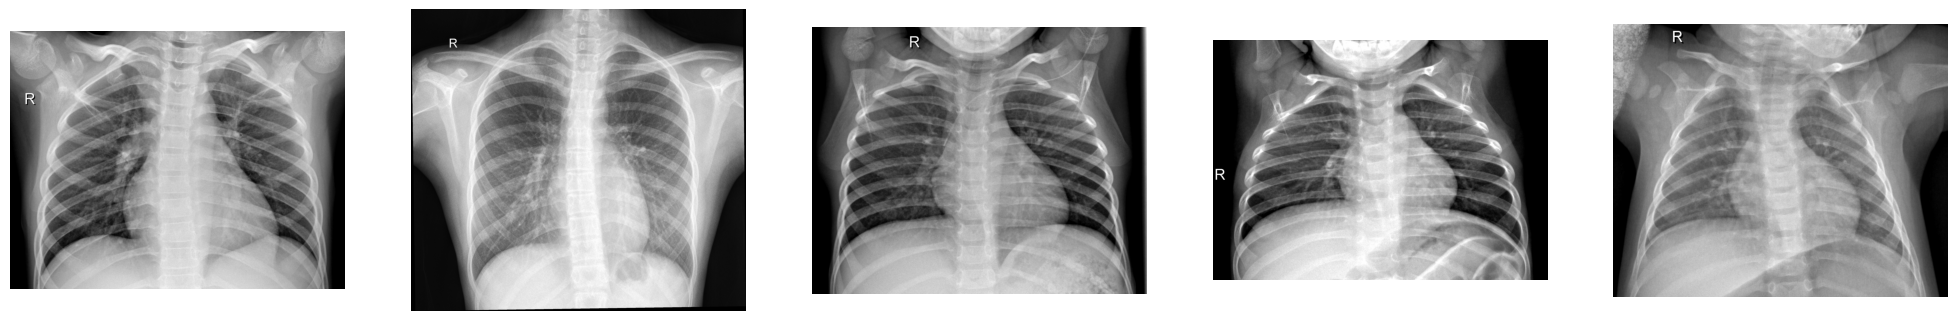

['/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0180-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-0828-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0394-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0350-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0345-0001.jpeg']


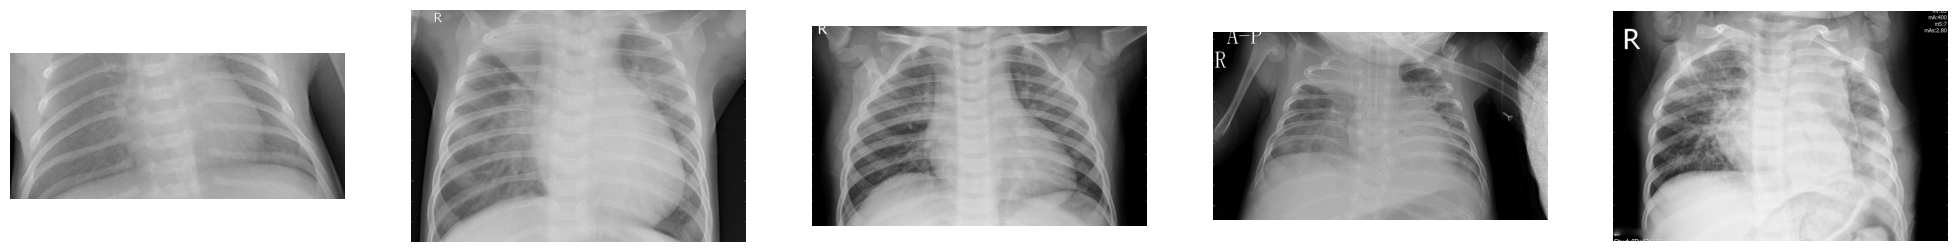

['/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1676_bacteria_4441.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person25_bacteria_113.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person146_virus_296.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1893_bacteria_4781.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1338_bacteria_3395.jpeg']


In [215]:
num_images_to_display = 5

train_normal_path, train_pneumonia_path = normal_n_pneumonia_paths(train_path)
print(train_normal_path)

list_random_images_paths_normal = select_n_display_images_from_folder(train_normal_path, num_images_to_display)
print(list_random_images_paths_normal)

list_random_images_paths_pneumonia = select_n_display_images_from_folder(train_pneumonia_path, num_images_to_display)
print(list_random_images_paths_pneumonia)


### 3) Standardise the data

The data needs to have the same shape, rescaling pixel value to [0,1]

#### Reshape

In [216]:
from PIL import Image
from collections import defaultdict

# Verify the shapes existing

def count_num_images_shapes(folder_path):
    # Dictionary to count occurrences of each unique shape
    shape_counts = defaultdict(int)

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg")):
            file_path = os.path.join(folder_path, filename)
            with Image.open(file_path) as img:
                shape = img.size  # (width, height)
                shape_counts[shape] += 1  # Count occurrences of each shape

    # Print unique shapes and their counts
    #for shape, count in shape_counts.items():
    #    print(f"Shape {shape}: {count} images")
    nb_shapes = 10
    if len(shape_counts.items()) > nb_shapes:
      print(f"There are more than {nb_shapes} different shapes in this dictionary.")

    return shape_counts

In [217]:
dictionary_shapes = count_num_images_shapes(train_normal_path)

There are more than 10 different shapes in this dictionary.


All the shapes are different, let's try ro find a shape that would work on all images, starting with the minimum shape (both width and height).

In [218]:
list_shapes = list(dictionary_shapes.keys())

# Get the min width and heigth
min_width, min_height = list(map(min, zip(*list_shapes)))
print(f"Min width: {min_width} \nMin height: {min_height}")

Min width: 912 
Min height: 672


We like powers of 2 for shapes as it works very well with maximisation of physical space, pooling steps, etc.

Let's reshape our images to (512, 512) wich is the closest power of 2 to the shapes above, and obviously it's a lower value to avoid using padding on images.

In [219]:
def resize_images_in_folder(folder_path, target_size, nb_images):
    # Dictionary to store resized image variables
    resized_images = {}
    count = 0
    # Loop through images and resize in-memory
    for filename in os.listdir(folder_path):

        if filename.lower().endswith((".jpg", ".jpeg")):
            file_path = os.path.join(folder_path, filename)

            # Open and resize the image
            img = Image.open(file_path)
            img_resized = img.resize(target_size)  # Resize in memory

            # Store in dictionary
            resized_images[filename] = img_resized

        if count > nb_images:
          break

    return resized_images

In [220]:
width = 64
height = 64
target_size = (width, height)  # Desired shape
nb_images = 10 # We just want to berify the data not load the whole dataset
dict_resized_images = resize_images_in_folder(train_normal_path, target_size, nb_images)

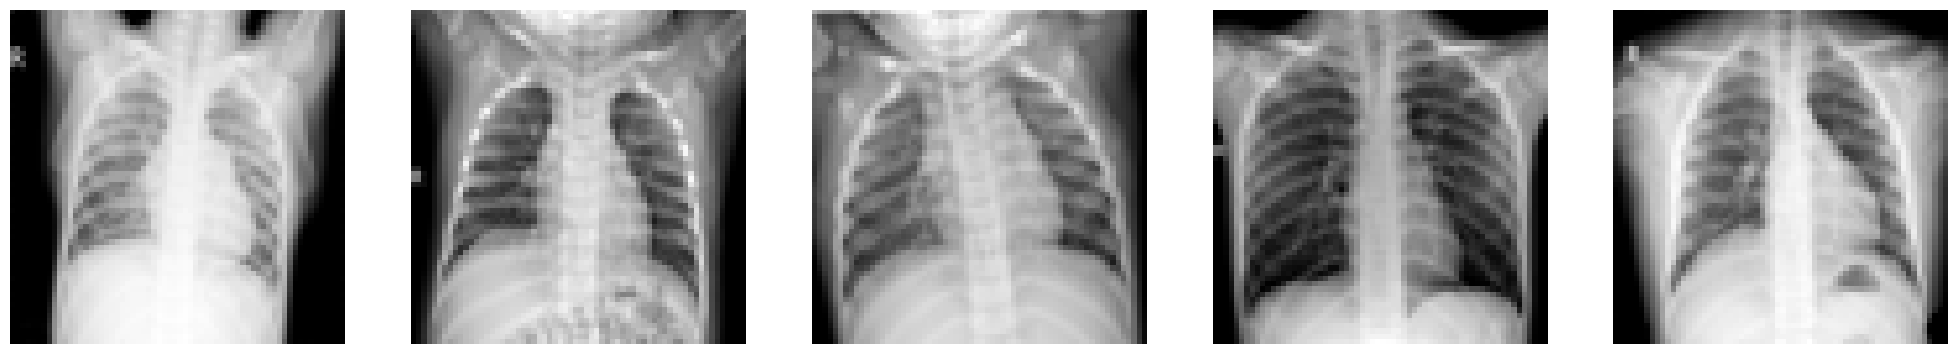

In [221]:
# Show resized images (for verification)

num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # One row, multiple columns

for ax, img in zip(axes, list(dict_resized_images.values())):
    ax.imshow(img, cmap="gray")
    ax.axis("off")  # Hide axes

All images seem to have been resized without any issues, let's start loading the whole dataset for training.

In [222]:
import os

def count_files_and_classes(folder_path):
    """
    Count the number of files and classes in a folder where each subfolder represents a class.

    Args:
        folder_path (str): Path to the root folder containing subfolders of images.

    Returns:
        dict: A dictionary with class names as keys and the number of images as values.
        int: Total number of images.
        int: Total number of classes.
    """
    # Get the list of subfolders (classes)
    class_names = sorted(os.listdir(folder_path))
    num_classes = len(class_names)

    # Count the number of files in each class
    class_counts = {}
    total_files = 0

    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):  # Ensure it's a directory
            num_files = len(os.listdir(class_folder))
            class_counts[class_name] = num_files
            total_files += num_files

    return class_counts, total_files, num_classes

# Check the training dataset
class_counts, total_files, num_classes = count_files_and_classes(train_path)

# Print the results
print("Training class counts:", class_counts)
print("Training total number of files:", total_files)
print("Training total number of classes:", num_classes)

Training class counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Training total number of files: 5216
Training total number of classes: 2


In [223]:
# Check the Validation dataset
class_counts, total_files, num_classes = count_files_and_classes(val_path)

# Print the results
print("Validation class counts:", class_counts)
print("Validation total number of files:", total_files)
print("Validation total number of classes:", num_classes)

Validation class counts: {'NORMAL': 8, 'PNEUMONIA': 8}
Validation total number of files: 16
Validation total number of classes: 2


In [224]:
import tensorflow as tf

# Define image size
width = 64
height = 64
target_size = (width, height)  # Desired shape
batch_size = 32

# Create training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=target_size,
    label_mode="binary",  # Use "binary" for binary classification
    batch_size=batch_size,
    color_mode="grayscale",  # Convert images to grayscale
    shuffle=True,
    seed=42,
)

# Create validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    image_size=target_size,
    label_mode="binary",  # Use "binary" for binary classification
    batch_size=batch_size,
    color_mode="grayscale",  # Convert images to grayscale
    shuffle=False,  # No need to shuffle validation data
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [225]:
# Inspect the first batch of the training dataset
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape)  # Should be (batch_size, 64, 64, 1)
    print("Labels shape:", labels.shape)  # Should be (batch_size,)
    print("Labels:", labels.numpy())  # Should be 0 (NORMAL) or 1 (PNEUMONIA)

Images shape: (32, 64, 64, 1)
Labels shape: (32, 1)
Labels: [[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [226]:
# Inspect the first batch of the validation dataset
for images, labels in val_dataset.take(1):
    print("Images shape:", images.shape)  # Should be (batch_size, 64, 64, 1)
    print("Labels shape:", labels.shape)  # Should be (batch_size,)
    print("Labels:", labels.numpy())  # Should be 0 (NORMAL) or 1 (PNEUMONIA)

Images shape: (16, 64, 64, 1)
Labels shape: (16, 1)
Labels: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


### 4) Creation of model

In [227]:
import keras
from keras import layers

def basic_CNN_model(input_shape, nb_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Conv2D(128, 3, strides=2, padding="same")(inputs) # Picture of shape (256,256) after
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x) # It's 256 because the shape of the image at that stage is (256,256)
    outputs = layers.Dense(nb_classes , activation="sigmoid")(x) # We return the probability of belinging to a certain class
    return keras.Model(inputs, outputs)

### 5) Training

In [228]:
input_shape = (width, height, 1)  # Desired shape
nb_classes = 1

model = basic_CNN_model(input_shape,nb_classes)

model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,779,265 (64.01 MB)

 Trainable params: 16,779,009 (64.01 MB)

 Non-trainable params: 256 (1.00 KB)

In [229]:
model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]


In [230]:
epochs = 10

history = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_dataset,
    verbose=1
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 624ms/step - acc: 0.8634 - loss: 4.2500 - val_acc: 0.6875 - val_loss: 8.8222
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 601ms/step - acc: 0.9686 - loss: 0.2742 - val_acc: 0.7500 - val_loss: 3.4969
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 655ms/step - acc: 0.9794 - loss: 0.1782 - val_acc: 0.7500 - val_loss: 1.3759
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 607ms/step - acc: 0.9691 - loss: 0.2647 - val_acc: 0.5625 - val_loss: 8.6498
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 599ms/step - acc: 0.9862 - loss: 0.1158 - val_acc: 0.9375 - val_loss: 0.3128
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 599ms/step - acc: 0.9853 - loss: 0.0967 - val_acc: 0.5000 - val_loss: 13.0692
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 592ms/step - acc: 0.9750 - loss: 0.1836 - val_acc: 0.9375 - val_loss: 0.8179
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 853ms/step - acc: 0.9880 - loss: 0.0977 - val_acc: 0.8750 - val_loss: 0.8894
Epoch 9/10
163/163 ━━━━━━

In [231]:
# Access history data
print(history.history.keys())  # Shows available metrics like loss, accuracy, etc.
print(history.history['loss'])  # Prints loss values per epoch
print(history.history['acc'])  # Prints accuracy values per epoch

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])
[1.7582757472991943, 0.3009607195854187, 0.20409835875034332, 0.20601050555706024, 0.08625230938196182, 0.08875475078821182, 0.19534887373447418, 0.13267704844474792, 0.0354253351688385, 0.03186331316828728]
[0.9162193536758423, 0.9658742547035217, 0.9754601120948792, 0.9745015501976013, 0.987730085849762, 0.9861963391304016, 0.9745015501976013, 0.9831288456916809, 0.9950153231620789, 0.9942484498023987]


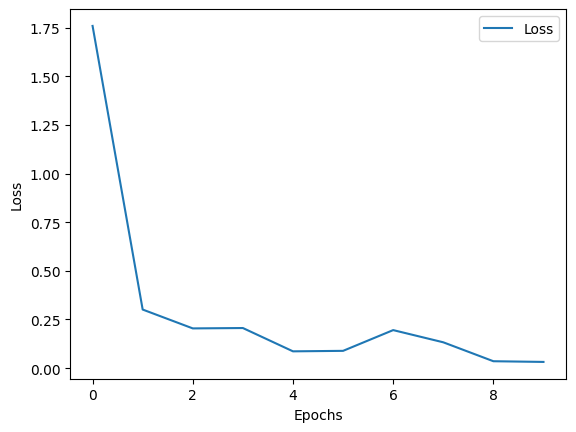

In [232]:
# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()